# Telecom     
A continuación, se genera el código de solución para proveer un modelo eficiente para la predicción de clientes que podrían llegar a cancelar su suscripción de los servicios de Telecom. 

Se llevarán a cabo los siguientes pasos:
- Unificación de celdas para lograr más precisión en la predicción.
- Segmentación de datos en: prueba, validación y entrenamiento.
- Comparación de diferentes modelos de clasificación usando métricas AUC, F1, Recall y Precisión para valorar.
- Ejercicio de comprobación del modelo y sus métricas con el segmento de prueba. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, roc_curve, roc_auc_score, precision_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import seaborn as sns
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier

In [3]:
df_contract = pd.read_csv(r"C:\Users\Sergio\Desktop\Tripleten\Final DS\final_provider\contract.csv")
df_internet = pd.read_csv(r"C:\Users\Sergio\Desktop\Tripleten\Final DS\final_provider\internet.csv")
df_phone = pd.read_csv(r"C:\Users\Sergio\Desktop\Tripleten\Final DS\final_provider\phone.csv")

In [4]:
merge_1 = df_contract.merge(df_phone, on='customerID')

In [5]:
df_modificado = merge_1.merge(df_internet, on='customerID')

In [6]:
df_modificado.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [7]:
df_final = df_modificado.copy()

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   MultipleLines     4835 non-null   object 
 9   InternetService   4835 non-null   object 
 10  OnlineSecurity    4835 non-null   object 
 11  OnlineBackup      4835 non-null   object 
 12  DeviceProtection  4835 non-null   object 
 13  TechSupport       4835 non-null   object 
 14  StreamingTV       4835 non-null   object 
 15  StreamingMovies   4835 non-null   object 
dtypes: float64(1), object(15)
memory usage: 60

In [9]:
display(df_final.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,No,DSL,Yes,No,Yes,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Yes,Fiber optic,No,Yes,No,No,Yes,No


## Transformación de datos   
Se transforman datos object a float por ser numéricos.

In [11]:
df_final['TotalCharges'] = df_final['TotalCharges'].replace(' ', np.nan)
df_final['TotalCharges'] = pd.to_numeric(df_final['TotalCharges'])
df_final['TotalCharges'] = df_final['TotalCharges'].fillna(df_final['TotalCharges'].mean())

Se transforman datos object a date cuando así se requiere. 

In [13]:
df_final['BeginDate'] = pd.to_datetime(df_final['BeginDate'])

Se usa la columna EndDate para crear una más y definir quién ha cancelado su contrato y quién no. En la columna 'Cancelled', 1 definirá quién sí canceló, y 0 quien no.

In [15]:
df_final['Cancelled'] = df_final['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        4835 non-null   object        
 1   BeginDate         4835 non-null   datetime64[ns]
 2   EndDate           4835 non-null   object        
 3   Type              4835 non-null   object        
 4   PaperlessBilling  4835 non-null   object        
 5   PaymentMethod     4835 non-null   object        
 6   MonthlyCharges    4835 non-null   float64       
 7   TotalCharges      4835 non-null   float64       
 8   MultipleLines     4835 non-null   object        
 9   InternetService   4835 non-null   object        
 10  OnlineSecurity    4835 non-null   object        
 11  OnlineBackup      4835 non-null   object        
 12  DeviceProtection  4835 non-null   object        
 13  TechSupport       4835 non-null   object        
 14  StreamingTV       4835 n

Se ve una reducción de los datos, sin embargo, esto se debe a que, al hacer merge, se conservan aquellos datos que se repiten en los 3 dataframes.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con el análisis inicial y el procesamiento de tus datos, es clave tener los datos adecuados para poder tener análisis y entrenamientos correctos
</div>

### Análisis exploratorio de datos

**Cancelación de clientes**

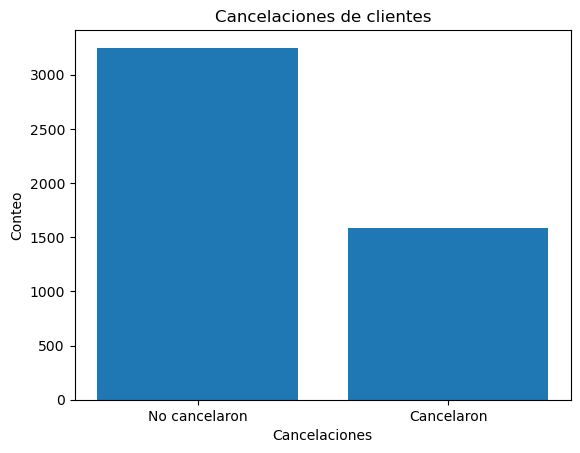

In [21]:
cancelaciones = df_final['Cancelled'].value_counts().sort_index()

plt.bar(cancelaciones.index, cancelaciones.values)

plt.xticks([0, 1], ['No cancelaron', 'Cancelaron'])
plt.xlabel('Cancelaciones')
plt.ylabel('Conteo')
plt.title('Cancelaciones de clientes')
plt.show()

Hay un desequilibrio de datos ya que la cantidad de clientes que cancelaron supera a la de los que no cancelaron. Se deberá llevar a cabo un sobremuestreo o submuestreo dependiendo de la cantidad de datos disponibles para así tener una predicción en los modelos más adecuada. 

**Charges**

C:\Users\Sergio\AppData\Local\Temp\ipykernel_18008\3165291999.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([charges_no, charges_sí], labels=['Costo total no cancelaron', 'Costo total sí cancelaron'])


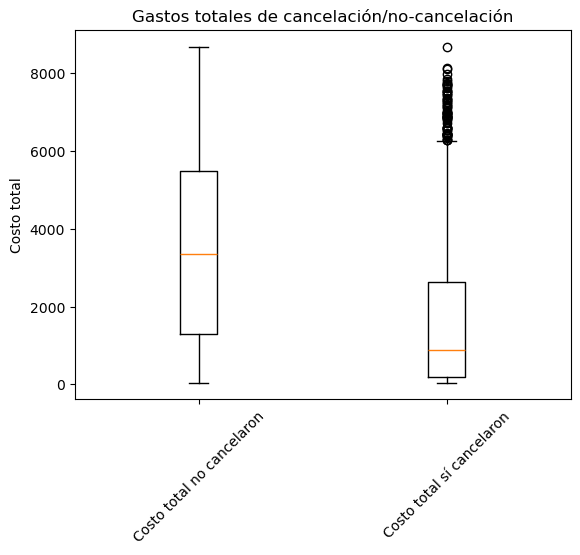

In [24]:
charges_no = df_final[df_final['Cancelled'] == 0]['TotalCharges']
charges_sí = df_final[df_final['Cancelled'] == 1]['TotalCharges']

plt.boxplot([charges_no, charges_sí], labels=['Costo total no cancelaron', 'Costo total sí cancelaron'])
plt.xticks(rotation=45)
plt.title('Gastos totales de cancelación/no-cancelación')
plt.ylabel('Costo total')
plt.show()

Hay valores atípicos en cuanto a los clientes que sí cancelaron. Estos podrían afectar los futuros análisis, por lo que se procederá a a hacer un análisis más exaustivo al respecto. 

**Charges / Cancelación**

Se procede a eliminar las columnas que no nos brindan información, como customerID, así como se unifican las de los servicios, para poder analizar si hay una relación entre servicios y clientes que han cancelado.

In [28]:
df_model = df_final.drop(columns=['customerID', 'BeginDate', 'EndDate'])

In [29]:
df_model.columns = df_model.columns.str.replace(' ', '_')

Ahora se usa getDummies para poder tener valores numéricos y juntar las columnas de servicios en una sola. 

In [31]:
df_model = pd.get_dummies(df_model, drop_first=True)

In [32]:
df_model['servicios_activos'] = df_model[[
    'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
    'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'
]].sum(axis=1)
df_model = df_model.drop(columns=['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
    'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'])

In [33]:
df_model.columns

Index(['MonthlyCharges', 'TotalCharges', 'Cancelled', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'servicios_activos'],
      dtype='object')

In [34]:
cancelados = df_model[df_model['Cancelled'] == 1].copy()

Q1 = cancelados['TotalCharges'].quantile(0.25)
Q3 = cancelados['TotalCharges'].quantile(0.75)

IQR = Q3 - Q1

límite_i = Q1 - 1.5 * IQR
límite_s = Q3 + 1.5 * IQR

cancelados['Atípicos'] = (
    (cancelados['TotalCharges'] < límite_i) | 
    (cancelados['TotalCharges'] > límite_s)
)
cantidad_cancelados = cancelados['Atípicos'].value_counts()
proporcion_can = cantidad_cancelados / len(cancelados) * 100

print(proporcion_can)

Atípicos
False    95.523329
True      4.476671
Name: count, dtype: float64


El 4.4% de clientes que cancelaron son datos atípicos en cuanto a TotalCharges.

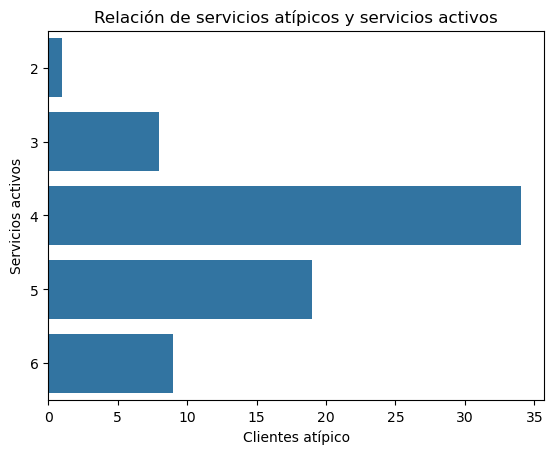

In [36]:
cancelados_1 = cancelados[cancelados['Atípicos']]

sns.countplot(y='servicios_activos', data=cancelados_1)
plt.title('Relación de servicios atípicos y servicios activos')
plt.xlabel('Clientes atípico')
plt.ylabel('Servicios activos')
plt.show()

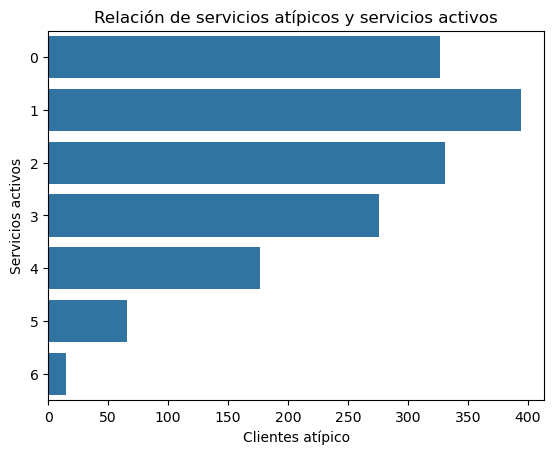

In [37]:
cancelados_gral = df_model[df_model['Cancelled'] == 1]

sns.countplot(y='servicios_activos', data=cancelados_gral)
plt.title('Relación de servicios atípicos y servicios activos')
plt.xlabel('Clientes atípico')
plt.ylabel('Servicios activos')
plt.show()

In [38]:
df_model['Atípicos'] = cancelados['Atípicos'].fillna(False)
df_model['Atípicos'] = df_model['Atípicos'].astype(bool)
df_model['Atípicos'] = df_model.index.isin(cancelados[cancelados['Atípicos']].index)

atípicos_can = df_model[(df_model['Cancelled'] == 1) & (df_model['Atípicos'])]
cancel_ser = df_model[(df_model['Cancelled'] == 1) & (~df_model['Atípicos'])]

promedio_atípicos = atípicos_can['servicios_activos'].mean()
promedio_cancel_ser = cancel_ser['servicios_activos'].mean()

print(f"Promedio de servicios de clientes atípicos cancelados: {promedio_atípicos:.2f}")
print(f"Promedio de servicios de clientes que cancelaron en general: {promedio_cancel_ser:.2f}")

Promedio de servicios de clientes atípicos cancelados: 4.38
Promedio de servicios de clientes que cancelaron en general: 1.78


Los clientes atípicos en cuanto al TotalCharges muestran tendencia a tener más servicios contratados, ya que la mayoría de los que cancelaron sin ser atípicos tienen de como promedio 1.78 servicios, mientras los atípicos tienen 4.38 servicios contratados. Podría estar relacionado el ser atípico con la cantidad de servicios. 

In [40]:
pay_col = [col for col in df_model.columns if col.startswith('PaymentMethod_')]
pago_atípico = cancelados.groupby('Atípicos')[pay_col].mean()

print('El método de pago por grupo es:')
print(pago_atípico)

El método de pago por grupo es:
          PaymentMethod_Credit card (automatic)  \
Atípicos                                          
False                                  0.120132   
True                                   0.309859   

          PaymentMethod_Electronic check  PaymentMethod_Mailed check  
Atípicos                                                              
False                           0.612541                    0.133993  
True                            0.450704                    0.000000  


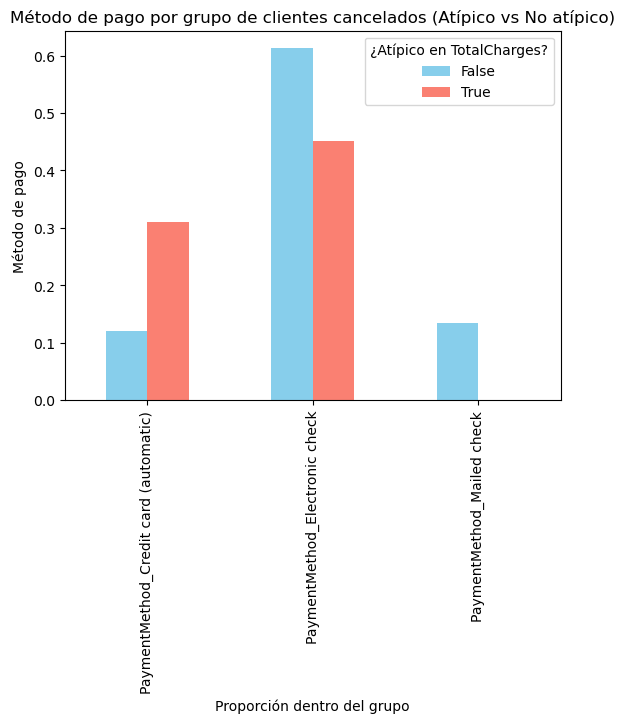

In [41]:
pago_atípico.T.plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Método de pago por grupo de clientes cancelados (Atípico vs No atípico)')
plt.xlabel('Proporción dentro del grupo')
plt.ylabel('Método de pago')
plt.legend(title='¿Atípico en TotalCharges?')
plt.show()

Los clientes atípicos tienen sus métodos de pago de dos formas, ambas electrónicas: pago automático de tarjeta de crédito, y por chece electrónico. No usan formas tradicionales. 

**Servicios**    
Ahora se analizan los servicios contratados en la clientela. 

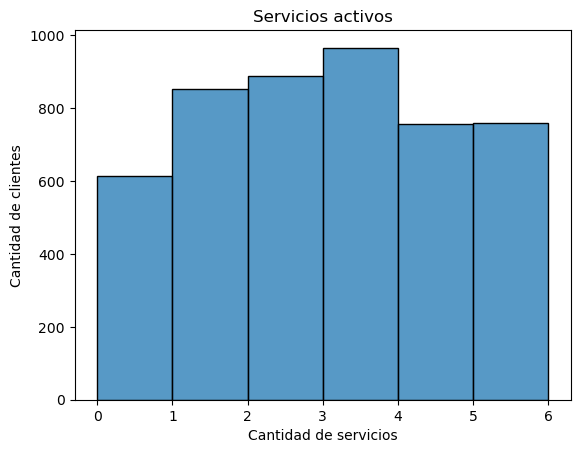

In [44]:
sns.histplot(df_model['servicios_activos'], bins=6)

plt.title('Servicios activos')
plt.xlabel('Cantidad de servicios')
plt.ylabel('Cantidad de clientes')
plt.show()

In [45]:
df_model['Cancelled'].value_counts()

Cancelled
0    3249
1    1586
Name: count, dtype: int64

Los clientes tienden a tener, en su mayoría, de 1 a 4 servicios, por lo que los clientes atípicos, no parecen salirse de la generalidad. Siguel el mismo patrón. 

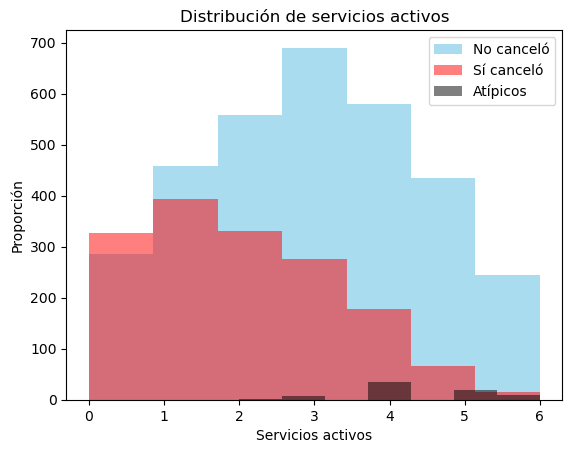

In [47]:
cancelados = df_model[df_model['Cancelled'] == 1]['servicios_activos']
no_cancelados = df_model[df_model['Cancelled'] == 0]['servicios_activos']
atipicos = df_model[df_model['Atípicos']]['servicios_activos']

plt.hist(no_cancelados, bins=7, alpha=0.7, label='No canceló', color='skyblue')
plt.hist(cancelados, bins=7, alpha=0.5, label='Sí canceló', color='red')
plt.hist(atipicos, bins=7, alpha=0.5, label='Atípicos', color='black')

plt.title('Distribución de servicios activos')
plt.xlabel('Servicios activos')
plt.ylabel('Proporción')
plt.legend()
plt.show()

Los clienes que cancelaron muestran una tendencia mayor a tener más servicios contratados que los que no cancelaron. Sin embargo, la proporción de servicios activos de los atípicos es mayor que los cancelados normales. Así que se dejarán dentro del análisis los atípicos, pues brindan información valiosa. 

In [49]:
df_model.drop(['Atípicos'], axis=1)

,MonthlyCharges,TotalCharges,Cancelled,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,servicios_activos
0,56.95,1889.50,0,True,False,False,False,False,True,False,False,2
1,53.85,108.15,1,False,False,True,False,False,True,False,False,2
2,70.70,151.65,1,False,False,True,False,True,False,False,True,0
3,99.65,820.50,1,False,False,True,False,True,False,True,True,3
4,89.10,1949.40,0,False,False,True,True,False,False,True,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4830,78.70,1495.10,0,False,False,True,False,False,False,False,True,1
4831,84.80,1990.50,0,True,False,True,False,False,True,True,False,5
4832,103.20,7362.90,0,True,False,True,True,False,False,True,True,4
4833,74.40,306.60,1,False,False,True,False,False,True,True,True,0


<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Antes de pasar a la parte del entrenamiento deberías tener aquí la parte del EDA donde revises las variables a utilizar mediante gráficas 
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Correcto, de esta forma el EDA deja mucho más claro con que datos se trabajará y es más fácil poder ver cómo estos podrían afectar a los modelos
</div>

### Segmentación    
Se segmenta en conjuntos de entrenamiento y validación:    
Prueba: 20%     
Validación: 20%     
Entrenamiento: 60%

Se genera segmento de prueba.

In [54]:
x = df_model.drop(columns=['Cancelled'])
y = df_model['Cancelled']

In [55]:
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_ent, x_val, y_ent, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42)

print(f"Entrenamiento: {x_ent.shape}, Validación: {x_val.shape}, Prueba: {x_test.shape}")

Entrenamiento: (2901, 12), Validación: (967, 12), Prueba: (967, 12)


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien, segmentaste los datos de manera adecuada para validar los entrenamientos
</div>

### Función de entrenamiento    
Se crea una función de entrenamiento para los distintos modelos. Una se usará con sobremuestreo de datos, y la otra sin sobremuestreo, usando classification_report. 

In [58]:
def entrenamiento_modelo_sobremuestreo(modelo, x_train, y_train, x_val, y_val):
    modelo.fit(x_train, y_train)
    modelo_pred = modelo.predict(x_val)

    f1 = f1_score(y_val, modelo_pred)
    recall = recall_score(y_val, modelo_pred)
    precisión = precision_score(y_val, modelo_pred)

    if hasattr(modelo, 'predict_proba'):
        score = modelo.predict_proba(x_val)[:, 1]
        auc = roc_auc_score(y_val, score)
    else:
        auc = 'No disponible'

    print(f"Modelo: {modelo.__class__.__name__}")
    print(f"AUC: {auc}")
    print(f"Precisión: {precisión}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")

In [59]:
def entrenamiento_classification(modelo, x_train, y_train, x_val, y_val):
    modelo.fit(x_train, y_train)
    modelo_pred = modelo.predict(x_val)

    if hasattr(modelo, 'predict_proba'):
        score = modelo.predict_proba(x_val)[:, 1]
        auc = roc_auc_score(y_val, score)
    else:
        auc = 'No disponible'

    print(f"\nModelo: {modelo.__class__.__name__}")
    print(f"AUC: {auc}")
    print("\nClassification report:")
    print(classification_report(y_val, modelo_pred))

### Creación de prueba de cordura

Se usa DummyClassifier para la prueba de cordura

In [61]:
cordura = DummyClassifier(strategy='stratified', random_state=42)
cordura.fit(x_ent, y_ent)

pred_dummy= cordura.predict(x_val)

cordura_f1 = f1_score(y_val, pred_dummy)
recall_cordura = recall_score(y_val, pred_dummy)
precisión_dummy = precision_score(y_val, pred_dummy)

print(f"F1 de prueba de cordura: {cordura_f1}")
print(f"Recall de prueba de cordura: {recall_cordura}")
print(f"Precisión de prueba de cordura: {precisión_dummy}")

F1 de prueba de cordura: 0.2969004893964111
Recall de prueba de cordura: 0.2879746835443038
Precisión de prueba de cordura: 0.3063973063973064


El modelo de la prueba de cordura al usar el azar, nos da una proporción del 28% de los casos reales positivos detectados, mientras que por el F1 nos damos cuenta de que detecta demasiados casos de falso positivo. Para finalizar, de los predichos, sólo el 29% eran positivos reales.     

Estas métricas nos ayudarán a definir la base sobre la cual se analizarán los otros modelos. 

### Balance de datos

In [64]:
print(y_ent.value_counts())

Cancelled
0    1957
1     944
Name: count, dtype: int64


Hay un leve desbalanceo en los datos, por lo que se procederá con un sobremuestreo para no perder datos ya que no son muy numerosos. 

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, siempre en problemas de clasificación antes de pasar a los entrenamientos se debe revisar el balance de clases para escoger la estrategia que mejor se adapte al caso
</div>

### Sobremuestreo de datos    
Se usarán dos técnicas de sobremuestreo: bucle y smote, y se compararán los resultados de ambos para tener una mejor exactitud del cálculo.

In [68]:
def upsample (features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    x_ent_bucle = pd.concat([features_zeros] + [features_ones] * repeat)
    y_ent_bucle = pd.concat([target_zeros] + [target_ones] * repeat)

    x_ent_bucle, y_ent_bucle = shuffle(x_ent_bucle, y_ent_bucle, random_state=42)

    return x_ent_bucle, y_ent_bucle

In [69]:
x_ent_bucle, y_ent_bucle = upsample(x_ent, y_ent, 2)

In [70]:
print(x_ent_bucle.shape)
print(y_ent_bucle.shape)

(3845, 12)
(3845,)


### Entrenamiento de modelos   
Se procede al entrenamiento de los modelos con los dos conjuntos de sobremuestreo para elegir el ideal.

In [72]:
Logistic = LogisticRegression(solver='liblinear')

entrenamiento_modelo_sobremuestreo(Logistic, x_ent_bucle, y_ent_bucle, x_val, y_val)

Modelo: LogisticRegression
AUC: 0.8286132337786073
Precisión: 0.5783410138248848
Recall: 0.7943037974683544
F1: 0.6693333333333333


In [73]:
logistic_class = LogisticRegression(solver='liblinear')

entrenamiento_classification(logistic_class, x_ent, y_ent, x_val, y_val)


Modelo: LogisticRegression
AUC: 0.8061939761613097

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       651
           1       0.64      0.56      0.60       316

    accuracy                           0.75       967
   macro avg       0.72      0.70      0.71       967
weighted avg       0.75      0.75      0.75       967



En caso de logistic_regression, el set sin balanceo de clases da mejor rendimiento. Tiene un F1 de predicción del 75% de los casos correctamente, mientra que el balanceo da un 65%, 

**DecisionTreeClassifier**    
Primero se encuenran los parámetros ideales.

In [76]:
tree_bucle = DecisionTreeClassifier(random_state=42)

hiperparámetros = {
    'max_depth' : [5, 10, 15, 20, None],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [1, 2, 5, 10],
    'max_leaf_nodes' : [None, 10, 20, 30, 50, 100]
}

params_tree = RandomizedSearchCV(
    estimator=tree_bucle,
    param_distributions=hiperparámetros,
    n_iter=50, 
    cv=5,
    random_state=42, 
    n_jobs=-1
)

params_tree.fit(x_ent_bucle, y_ent_bucle)

print('Mejores hiperparámetros para bucle', params_tree.best_params_)

Mejores hiperparámetros para bucle {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': None}


In [77]:
tree_class = DecisionTreeClassifier(random_state=42)

hiperparámetros = {
    'max_depth' : [5, 10, 15, 20, None],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [1, 2, 5, 10],
    'max_leaf_nodes' : [None, 10, 20, 30, 50, 100]
}

params_tree_class = RandomizedSearchCV(
    estimator=tree_class,
    param_distributions=hiperparámetros,
    n_iter=50, 
    cv=5,
    random_state=42, 
    n_jobs=-1
)

params_tree_class.fit(x_ent, y_ent)

print('Mejores hiperparámetros para bucle', params_tree_class.best_params_)

Mejores hiperparámetros para bucle {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_leaf_nodes': 10, 'max_depth': None}


In [78]:
Tree_bucle = DecisionTreeClassifier(random_state=42, min_samples_split=5,
                                        min_samples_leaf=1,
                                        max_leaf_nodes=100,
                                       max_depth=None)

entrenamiento_modelo_sobremuestreo(Tree_bucle, x_ent_bucle, y_ent_bucle, x_val, y_val)

Modelo: DecisionTreeClassifier
AUC: 0.7633922495090318
Precisión: 0.5563218390804597
Recall: 0.7658227848101266
F1: 0.644474034620506


In [79]:
Tree_class = DecisionTreeClassifier(random_state=42, min_samples_split=5,
                                        min_samples_leaf=5,
                                        max_leaf_nodes=50,
                                       max_depth=5)

entrenamiento_classification(Tree_class, x_ent, y_ent, x_val, y_val)


Modelo: DecisionTreeClassifier
AUC: 0.8193431721402322

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       651
           1       0.70      0.51      0.59       316

    accuracy                           0.77       967
   macro avg       0.74      0.70      0.71       967
weighted avg       0.76      0.77      0.76       967



La métrica F1 de DecisionTreeClassifier es apenas ligeramente mejor que LogisticRegression. El resultaod en este caso del modelo sin sobremuestreo es del 76%, contra el 64 del modelo con sobremuestreo, que es del 64%.

**RandomForestClassifier**

In [82]:
forest = RandomForestClassifier(random_state=42)

hiperparámetros_f = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [None, 10, 20, 30, 50],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : ['sqrt', 'log2', None]}

params_forest = RandomizedSearchCV(
    estimator=forest,
    param_distributions=hiperparámetros_f,
    n_iter=50, 
    cv=5, 
    random_state=42, 
    n_jobs=-1,
    verbose=1)

params_forest.fit(x_ent_bucle, y_ent_bucle)

print('Mejores parámetros para bucle:', params_forest.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para bucle: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}


In [83]:
forest_class = RandomForestClassifier(random_state=42)

hiperparámetros_f = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [None, 10, 20, 30, 50],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features' : ['sqrt', 'log2', None]}

params_forest_class = RandomizedSearchCV(
    estimator=forest_class,
    param_distributions=hiperparámetros_f,
    n_iter=50, 
    cv=5, 
    random_state=42, 
    n_jobs=-1,
    verbose=1)

params_forest_class.fit(x_ent, y_ent)

print('Mejores parámetros para classification:', params_forest_class.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros para classification: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}


In [84]:
forest_bucle = RandomForestClassifier(random_state=42,
                                      n_estimators=200,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      max_features='sqrt',
                                      max_depth=50)

entrenamiento_modelo_sobremuestreo(forest_bucle, x_ent_bucle, y_ent_bucle, x_val, y_val)

Modelo: RandomForestClassifier
AUC: 0.8006426335336094
Precisión: 0.5790960451977402
Recall: 0.6487341772151899
F1: 0.6119402985074627


In [85]:
forest_class = RandomForestClassifier(random_state=42,
                                      n_estimators=200,
                                      min_samples_split=10,
                                      min_samples_leaf=1,
                                      max_features='sqrt',
                                      max_depth=50)

entrenamiento_classification(forest_class, x_ent, y_ent, x_val, y_val)


Modelo: RandomForestClassifier
AUC: 0.8291066324447297

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       651
           1       0.67      0.61      0.64       316

    accuracy                           0.78       967
   macro avg       0.75      0.73      0.74       967
weighted avg       0.77      0.78      0.77       967



La métrica F1 del RandomForestClassifier es ligeramente mejor que los dos modelos anteriores por una diferencia mínima, sin embargo, el patrón se repite: el modelo sin sobremuestreo es mejor, con un 77% de casos predichos correctamente. 

In [87]:
lgbm = LGBMClassifier(random_state=42)

parámetros_light = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 20, -1],
    'num_leaves': [15, 31, 63, 127, 200, 255],
    'min_child_samples': [5, 10, 20, 30, 50],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
    'reg_alpha' : [0.1, 0.5, 1.0],
    'reg_lambda' : [0.1, 0.5, 1.0]
}

search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=parámetros_light,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_lgbm.fit(x_ent_bucle, y_ent_bucle)

print('Mejores hiperparámetros para LGBM bucle:', search_lgbm.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1888, number of negative: 1957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 3845, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491027 -> initscore=-0.035895
[LightGBM] [Info] Start training from score -0.035895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [88]:
lgbm_class = LGBMClassifier(random_state=42)

parámetros_light = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 20, -1],
    'num_leaves': [15, 31, 63, 127, 200, 255],
    'min_child_samples': [5, 10, 20, 30, 50],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
}

lgbm_c = RandomizedSearchCV(
    estimator=lgbm_class,
    param_distributions=parámetros_light,
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgbm_c.fit(x_ent_bucle, y_ent_bucle)

print('Mejores hiperparámetros para classification:', lgbm_c.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1888, number of negative: 1957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 3845, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491027 -> initscore=-0.035895
[LightGBM] [Info] Start training from score -0.035895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [89]:
lgbm = LGBMClassifier(random_state=42,
                            subsample=0.8,
                            num_leaves=255,
                            n_estimators=100,
                            min_child_samples=10,
                            max_depth=-10,
                            learning_rate=0.2)

entrenamiento_modelo_sobremuestreo(lgbm, x_ent_bucle, y_ent_bucle, x_val, y_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1888, number of negative: 1957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 3845, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491027 -> initscore=-0.035895
[LightGBM] [Info] Start training from score -0.035895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Modelo: LGBMClassifier
AUC: 0.7842316591806179
Precisión: 0.5718654434250765
Recall: 0.5917721518987342
F1: 0.5816485225505443


In [90]:
lgbm_class = LGBMClassifier(random_state=42,
                            subsample=0.8,
                            num_leaves=200,
                            n_estimators=100,
                            min_child_samples=30,
                            max_depth=-10,
                            learning_rate=0.2)

entrenamiento_classification(lgbm_class, x_ent, y_ent, x_val, y_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 944, number of negative: 1957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 2901, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.325405 -> initscore=-0.729042
[LightGBM] [Info] Start training from score -0.729042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

El caso de LGBMClassifier tiene un retroceso en la métrica F1 en comparación con los otros modelos, resulta ser la menos eficiente con un 74%.   


Todos los modelos tuvieron un mejor rendimiento en cuanto a F1 con los datos sin sobremuestreo. Esto se debió, probablemente, a que el sobremuestreo no fue suficiente para el buen entrenamiento de los modelos, o quizá que no era necesario dado que el desvalance no era tan marcado.

### Mejor modelo    
El mejor modelo sería, por una mínima diferencia, el RandomForestClassifier, por lo que ahora se procede a usarlo con el segmento de prueba y con datos sin sobremuestreo. Se usará DecisionTreeClassifier sólo como comparativa pues fue el segundo mejor modelo. 

In [93]:
forest_final = RandomForestClassifier(random_state=42,
                                      n_estimators=200,
                                      min_samples_split=10,
                                      min_samples_leaf=1,
                                      max_features='sqrt',
                                      max_depth=50)

entrenamiento_classification(forest_final, x_ent, y_ent, x_test, y_test)


Modelo: RandomForestClassifier
AUC: 0.8299508053941789

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       641
           1       0.68      0.58      0.63       326

    accuracy                           0.77       967
   macro avg       0.74      0.72      0.73       967
weighted avg       0.76      0.77      0.76       967



In [94]:
tree_final = DecisionTreeClassifier(random_state=42, min_samples_split=5,
                                        min_samples_leaf=5,
                                        max_leaf_nodes=50,
                                       max_depth=5)

entrenamiento_classification(tree_final, x_ent, y_ent, x_test, y_test)


Modelo: DecisionTreeClassifier
AUC: 0.818216839103012

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       641
           1       0.71      0.47      0.56       326

    accuracy                           0.75       967
   macro avg       0.74      0.68      0.70       967
weighted avg       0.75      0.75      0.74       967



## Mejor modelo    
El mejor modelo para los fines del análisis, ha sido el de RandomForestClassifier ya que sus métricas son las más altas.     
- Muestra un AUC de 82.9%, es su porcentaje de distinción de clases.
- La precisión de predición de valores positivos es del 76%.
- El recall, los positivos reales detectados, es de 77%.
- Para finalizar, el F1 e de 76%

# Informe final

### Objetivo

El objetivo de este análisis era encontrar el modelo ideal que permitiera saber a la empresa Telecom qué clientes llegarían a cancelar su servicio con base en la data proporcionada.

Para obtener el mejor modelo que diera solución a la solicitud de Telecom, se siguieron los siguientes pasos:

### Análisis y revisión de datos    
Con base en los dataframes que la empresa otorgó para el estudio, se eligieron aquellos que serían de utilidad para el análisis y se dejaron fuera aquellos (particularmente, aquél de datos personales como género, edad, etc.) que no.

### Preprocesamiento de datos    
Se analizaron los datos duplicados, vacíos y aquellos que eran atípicos. Asimismo, se eligieron los datos adecuados para el análisis, se dejaron fuera aquellos que no proporcionaban datos útiles, y se creó un dataframe único con datos unificados y todas aquellas variables útiles para el estudio.

### Reducción de datos por unión
El dataframe con los datos concernientes a los contratos tenía poco más de 7,000 registros, pero el dataframe final fue de 4,835, ya que al realizar el merge, se conservaron únicamente aquellos clientes cuyos datos se repetían en todos los dataframes relevantes.

### Clientes atípicos
Se encontró que los clientes atípicos (4.47% del total) tenían en promedio 4.38 servicios contratados, frente a los 1.78 de los no atípicos. Por lo tanto, se decidió mantener los datos atípicos ya que estos contenían información importante respecto a las posibles condiciones en las que los clientes deciden cancelar su plan. Había una relación directa entre la cantidad de servicios contratados y los clientes que cancelaron.   

La principal dificultad giró en torno a qué hacer con los datos atípicos, sin embargo, se decidió conservarlos ya que otorgan información valiosa en cuanto a los motivos por los que los clientes podrían cancelar. 

### Prueba de cordura    
Se llevó a cabo una prueba de cordura para comparar los modelos con una línea base (regresión lineal).

### Clasificación    
Se usaron modelos de clasificación ya que el objetivo era predecir una variable binaria: si el cliente canceló o no. Se utilizaron métricas adecuadas como precision, recall, f1-score y AUC, y se compararon los modelos con y sin sobremuestreo, ya que existía un desbalance leve en las clases.

### Sobremuestreo
Otra dificultad observada fue el desbalance de clases. Aunque no era extremo, se decidió comparar modelos entrenados con y sin sobremuestreo. Sin embargo, los modelos con sobremuestreo demostraron sobreentrenamiento, ya que obtenían métricas perfectas en el conjunto de validación, lo cual los hacía poco confiables.

### Comparativa de modelos (sin sobremuestreo)

| Modelo                 | AUC   | Precisión (weighted) | Recall (weighted) | F1-score (weighted) |
|------------------------|-------|-----------------------|--------------------|----------------------|
| LogisticRegression     | 0.78  | 0.75                  | 0.75               | 0.75                 |
| RandomForestClassifier | 0.82  | 0.76                  | 0.76               | 0.76                 |
| DecisionTreeClassifier | 0.74  | 0.71                  | 0.71               | 0.71                 |
| KNeighborsClassifier   | 0.73  | 0.72                  | 0.72               | 0.72                 |
| SVC                    | 0.75  | 0.72                  | 0.72               | 0.72                 |
| GradientBoosting       | 0.79  | 0.74                  | 0.74               | 0.74                 |


Nota: Las métricas corresponden a los valores ponderados (weighted average) en el conjunto de validación.

### Conclusión    
El mejor modelo fue RandomForestClassifier, con un F1-score de 0.76 sin sobremuestreo. Este modelo es capaz de predecir correctamente si un cliente cancelará su contrato en el 76% de los casos, balanceando adecuadamente precisión y sensibilidad.

Se recomienda actualizar el modelo con nueva data, especialmente aquella relacionada con promociones o paquetes ofrecidos a clientes con alto riesgo de cancelación, para evaluar su impacto.

Una posible estrategia sería ofrecer paquetes agrupados de servicios en lugar de permitir la selección aleatoria, lo que podría brindar una experiencia más personalizada y fomentar la permanencia del cliente.

Los modelos con sobremuestreo no fueron considerados viables debido al sobreajuste evidente que presentaron.